In [6]:
import pandas as pd
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
from tqdm import tqdm 
from urllib.parse import urljoin


## Initial data

In [123]:
db_pomoci = pd.read_csv("db_pomoci.csv")
black_list = ['http://www.dc-brno.cz']
df = db_pomoci.rename(columns={"Webová stránka" : "web", "Název":"nazev"})
df = df[(~df["web"].isna()) & (~df['web'].isin(black_list))]
df.loc[df['web'].str.startswith('www'), 'web'] = df['web'].str.replace('^www', 'https://www', regex=True)
# df['web'] = df['web'].str.replace('https://www', 'www')
# df['web'] = df['web'].str.replace('www', 'https://www')
df_agg = df.groupby("web")["Telefon"].agg(list)
df_agg["email"] = df.groupby("web")["E-mail"].agg(list)
df_agg = df_agg.reset_index().rename(columns={'web': 'web', 'Telefon': 'Telefon'})
df_agg = pd.DataFrame(df_agg)

# Scraped data

db_scraped = pd.read_csv("data/29_05/df_scraped_v2.csv")
df_res = db_scraped[~db_scraped["Phone Numbers"].isna()]
df_res = df_res.rename(columns={'web': 'web', 'Telefon': 'Telefon'})#.drop("Unnamed: 0", axis= 1)
df_res = df_res.rename(columns= {"Website":"web"})
df_res = df_res.rename(columns= {"Phone Numbers":"phones_scraped"})
df_res = df_res.rename(columns= {"Emails":"emails_scraped"})


maps_df = pd.read_csv("data/maps_results.csv",sep=";")
maps_df = maps_df.rename(columns={'Web': 'web', 'Phone': 'Telefon Mapy'})
mapy = maps_df[["web","Telefon Mapy"]]#,"Telefon Mapy"


In [124]:
print("df_agg", df_agg.shape)
print("df_res", df_res.shape)
print("df_mapy", mapy.shape)



df_agg (871, 2)
df_res (599, 3)
df_mapy (1456, 2)


In [125]:
df_res['phones_scraped'] = df_res['phones_scraped'].str.split(', ')
mapy['Telefon Mapy'] = mapy['Telefon Mapy'].str.split(', ')
df_res = df_res[["web","phones_scraped"]]
df_res['source'] = 'scraped'
df_agg['source'] = 'db'
mapy['source'] = 'mapy.cz'
#df_res['emails_scraped'] = df_res['emails_scraped'].str.split(', ')
#df_agg = df_agg.rename(columns= {"Telefon":"phones_scraped"})
df_res_exp = df_res.explode('phones_scraped').reset_index(drop=True)
mapy_exp = mapy.explode('Telefon Mapy').reset_index(drop=True)
mapy_exp = mapy_exp.rename(columns= {"Telefon Mapy":"Telefon"})
df_res_exp = df_res.rename(columns= {"phones_scraped":"Telefon"})
df_agg_exp = df_agg.explode('Telefon').reset_index(drop=True)
df_union = pd.concat([df_agg_exp, df_res_exp,mapy_exp])

/var/folders/rd/l77bltt96_97jdz4bbkmq5z40000gn/T/ipykernel_46796/1908990668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapy['Telefon Mapy'] = mapy['Telefon Mapy'].str.split(', ')
/var/folders/rd/l77bltt96_97jdz4bbkmq5z40000gn/T/ipykernel_46796/1908990668.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapy['source'] = 'mapy.cz'


In [126]:
mapy_exp

,web,Telefon,source
0,http://www.pdz.cz,778 526 216,mapy.cz
1,http://www.cdzopava.cz/,553 652 433,mapy.cz
2,http://www.cdzopava.cz/,723 457 998,mapy.cz
3,http://www.pdz.cz,469 626 383,mapy.cz
4,http://www.pdz.cz,774 915 755,mapy.cz
...,...,...,...
1634,www.praha.ymca.cz,775 317 814,mapy.cz
1635,http://www.ymkarium.ymca.cz,737 629 149,mapy.cz
1636,www.dixie.ymca.cz,737 872 116,mapy.cz
1637,http://www.usti.ymca.cz,475 220 831,mapy.cz


In [127]:
df_union.groupby("source").count()

,web,Telefon
source,,
db,1986,1971
mapy.cz,1267,1609
scraped,599,599


In [132]:
df_union[df_union["web"]=="www.zvole.info"]

,web,Telefon,source
1533,www.zvole.info,NaN,mapy.cz


In [128]:
set_unmatched = set(df_union[df_union["Telefon"].isna() & df_union["web"]!= 'email' ]["web"])


In [129]:
len(set_unmatched)

1009

In [63]:
#df_union['Telefon'] = df_union['Telefon'].str.replace(r'\s+', '', regex=True)
#df_grouped = pd.DataFrame(df_union.groupby('web').count().sort_values(by="Telefon",ascending=False))

In [130]:
df_grouped = df_union.groupby('web').count()

# Filter the DataFrame to get rows where the count of 'Telefon' is less than 1
filtered_df = df_grouped[df_grouped['Telefon'] < 1]

# Extract the list of 'web' values
web_list = filtered_df.index.tolist()
print(len(web_list))
for c in web_list:
    print(c)

6
http://www.ckp-dobrichovice.cz
http://www.fokus-mb.cz/klubko
https://www.milicak.cz
misa.zapletalova@tiscali.cz
www.milicak.cz
www.zvole.info


In [134]:
#df_union[df_union["web"] == 'asistovanekontakty.cz'].sort_values(by="Telefon")
web = 'https://www.zvole.info'
df_agg[df_agg["web"] == web].sort_values(by="Telefon")
df_res[df_res["web"] == web].sort_values(by="phones_scraped")

,web,phones_scraped,source
761,https://www.zvole.info,"[+420 257 760 337, 257 760 337]",scraped


In [14]:
preview = df_res.merge(df_agg , on="web")
preview = preview.merge(mapy_tel , on="web")
preview['phones_scraped'] = preview['phones_scraped'].str.split(', ')
preview


,web,phones_scraped,Telefon,Telefon Mapy
0,http://www.pdz.cz,"[121 407 9329, 64 24 22 18, 420 466 400 116]","[778 526 216, 469 626 383, 774 915 755]",778 526 216
1,http://www.pdz.cz,"[121 407 9329, 64 24 22 18, 420 466 400 116]","[778 526 216, 469 626 383, 774 915 755]","469 626 383, 774 915 755"
2,http://www.medsix.cz/?option=com_content&view=...,"[483 341 232, 483 300 087, 483 310 919, 483 34...",[483 341 267],483 341 267
3,https://jindrichuvhradec.charita.cz/sluzba/852/,"[731 402 982, 731 604 554, 605 849 877]","[731 402 982, 605 849 877]","731 402 982, 605 849 877"
4,https://www.homeopatiecz.com/,"[777 169 278, 736 660 315, 777 146 760, 725 76...",[736 660 315],736 660 315
...,...,...,...,...
612,https://www.firmy.cz/detail/13179143-phdr-tere...,[420 376 322 688],[376 322 688],376 322 688
613,https://search.seznam.cz/?q=psychiatrick%C3%A1...,[420608971030],[736 132 143],736 132 143
614,http://ssp-ol.cz/,[585 427 141],[774 406 453],774 406 453
615,http://www.psychoterapeuti.cz/adresar-psychote...,"[284 016 451, 736 660 315, 530 334 600, 775 18...",[466 611 601],466 611 601


In [1]:
df_agg.head()

NameError: name 'df_agg' is not defined

In [135]:
v1 = pd.read_csv('data/df_scraped.csv')
v2 = pd.read_csv('data/29_05/df_scraped_v2.csv')

In [138]:
v1.head()
#v2.head()

,Unnamed: 0,Website,Phone Numbers
0,0.0,http://www.pdz.cz,"121 407 9329, 64 24 22 18, 420 466 400 116"
1,1.0,http://www.medsix.cz/?option=com_content&view=...,"483 341 232, 483 300 087, 483 310 919, 483 341..."
2,2.0,https://www.osbonanza.cz,NaN
3,3.0,https://www.svetlokadanzs.cz,NaN
4,4.0,https://jindrichuvhradec.charita.cz/sluzba/852/,"731 402 982, 731 604 554, 605 849 877"


In [143]:
v1.isna().sum()

Unnamed: 0         2
Website            2
Phone Numbers    310
dtype: int64

In [140]:
v2.isna().sum()

Website            0
Emails           364
Phone Numbers    267
dtype: int64

In [141]:
v1.shape

(872, 3)

In [142]:
v2.shape

(866, 3)

In [1]:
import pandas as pd
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re



phone_regex = re.compile(r"""
    (?:
        \+420[-\s]?        # Optional country code +420 followed by an optional space or dash
    )?
    (?:
        \d{3}[-\s]?        # First part of the phone number (3 digits) followed by an optional space or dash
        \d{3}[-\s]?        # Second part of the phone number (3 digits) followed by an optional space or dash
        \d{3}              # Third part of the phone number (3 digits)
        |                  # OR
        \d{3}[-\s]?        # First part of the phone number (3 digits) followed by an optional space or dash
        \d{2}[-\s]?        # Second part of the phone number (2 digits) followed by an optional space or dash
        \d{2}[-\s]?        # Third part of the phone number (2 digits) followed by an optional space or dash
        \d{2}              # Fourth part of the phone number (2 digits)
    )
""", re.VERBOSE)
email_regex = re.compile(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}")

# Test the regex
test_numbers = [
    "+420 123 456 789",
    "+420-123-456-789",
    "123 456 789",
    "123 456 789 123",
    "123456789123",
    "774 97 97 14",
    "+420 774 97 97 14",
    "+420 565 552 604"
]

for number in test_numbers:
    match = phone_regex.search(number)
    if match:
        print(f"Matched: {match.group()}")
    else:
        print(f"No match: {number}")

Matched: +420 123 456 789
Matched: +420-123-456-789
Matched: 123 456 789
Matched: 123 456 789
Matched: 123456789
Matched: 774 97 97 14
Matched: +420 774 97 97 14
Matched: +420 565 552 604


In [2]:
df_scraped = pd.read_csv("../data/1_06/df_scraped_full.csv")

In [3]:
df_scraped.shape

(1882, 6)

In [4]:
df_scraped.head()

,Unnamed: 0,Base Website,Scraped Page,Page Type,Emails,Phone Numbers
0,0,http://www.adelafararova.cz/,http://www.adelafararova.cz/,main,255akleda77@gmail.comPal,"613 3827 66, 776 871 255, 670100-221, +420 776..."
1,1,http://www.adelafararova.cz/,http://www.adelafararova.cz/#kontakt,contact,255akleda77@gmail.comPal,"776 871 255, 670100-221, +420 776 871 255"
2,2,http://www.adelafararova.cz/,http://www.adelafararova.cz/template/contact,contact,255akleda77@gmail.comPal,"613 3827 66, +420 776 871 255"
3,3,http://www.ckp-dobrichovice.cz,http://www.ckp-dobrichovice.cz,main,"seminare@ckp-dobrichovice.cz, info@ckp-dobrich...","+420 777 773 014, +420 775 603 573, +420 773 3..."
4,4,http://www.ckp-dobrichovice.cz,https://www.ckp-dobrichovice.cz/kontakt/,contact,info@ckp-dobrichovice.cz,"+420 773 339 916, +420 723 603 600"


In [5]:
df_scraped[df_scraped["Phone Numbers"].isna()]

,Unnamed: 0,Base Website,Scraped Page,Page Type,Emails,Phone Numbers
14,14,http://www.medsix.cz,http://www.medsix.cz/web/jpol.html,contact,NaN,NaN
16,16,http://www.cheiront.cz,http://www.cheiront.cz/o-nas,contact,NaN,NaN
19,19,http://www.cheiront.cz/,http://www.cheiront.cz/o-nas,contact,NaN,NaN
23,23,http://obcanskaporadna.cz,http://obcanskaporadna.cz/o-nas/,contact,NaN,NaN
32,32,http://www.clovekvtisni.cz,https://klima.clovekvtisni.cz,contact,barbora.vrablikova@clovekvtisni.czKontakty,NaN
...,...,...,...,...,...,...
1832,181,https://www.psychoterapie-vysocina.cz,https://www.psychoterapie-vysocina.cz,main,NaN,NaN
1833,182,https://www.psycholog-jesenik.cz/,https://www.psycholog-jesenik.cz/,main,NaN,NaN
1836,185,https://www.zachranny-kruh.cz/,https://www.zachranny-kruh.cz/o-nas/,contact,NaN,NaN
1841,190,https://www.psychocentrumdomecek.cz,https://www.psychocentrumdomecek.cz/o-nas,contact,NaN,NaN


In [35]:
df_res = pd.read_csv("../data/1_06/df_scraped_full.csv")
df_res['phones_scraped'] = df_res['Phone Numbers'].str.split(', ')
df_res['emails_scraped'] = df_res['Emails'].str.split(', ')
df_res_phones = df_res[["Base Website", "Scraped Page","phones_scraped"]]
print(df_res_phones.shape)
df_res_exp = df_res_phones.explode('phones_scraped').reset_index(drop=True)
print(df_res_exp.shape)
# mapy['Telefon Mapy'] = mapy['Telefon Mapy'].str.split(', ')
# df_res = df_res[["web","phones_scraped"]]
# df_res['source'] = 'scraped'
# df_agg['source'] = 'db'
# mapy['source'] = 'mapy.cz'
# #df_agg = df_agg.rename(columns= {"Telefon":"phones_scraped"})
# df_res_exp = df_res.explode('phones_scraped').reset_index(drop=True)
# mapy_exp = mapy.explode('Telefon Mapy').reset_index(drop=True)
# mapy_exp = mapy_exp.rename(columns= {"Telefon Mapy":"Telefon"})
# df_res_exp = df_res.rename(columns= {"phones_scraped":"Telefon"})
# df_agg_exp = df_agg.explode('Telefon').reset_index(drop=True)
# df_union = pd.concat([df_agg_exp, df_res_exp,mapy_exp])

(1882, 3)
(16134, 3)


In [44]:
import phonenumbers
import phonenumbers.geocoder
def py_parse_phonenumber(num):
    try:
        parsed_num = phonenumbers.parse(num, 'CZ')
        phonenumbers.is_possible_number_with_reason(parsed_num)
        return {
            'formated_number':phonenumbers.format_number(parsed_num, phonenumbers.PhoneNumberFormat.E164),
            'number': parsed_num.national_number,
            'prefix': parsed_num.country_code,
            'country_code': phonenumbers.region_code_for_number(parsed_num),
            'valid': phonenumbers.is_valid_number(parsed_num),
            'possible': phonenumbers.is_possible_number(parsed_num),
            'parsed': True
        }
    except Exception as e:
        return {'number': num, 'prefix': None, 'country_code': None, 'valid': False, 'possible': False, 'parsed': False}

def udf(df: pd.DataFrame, column_name: str):
    results = df[column_name].apply(py_parse_phonenumber)
    parsed_df = pd.DataFrame(results.tolist())
    return parsed_df

def explode_df(df:pd.DataFrame, column_name:str) -> pd.DataFrame:
    #df_res = pd.read_csv("../data/1_06/df_scraped_full.csv")
    df_res = df
    df_res[f'{column_name}_scraped'] = df_res[column_name].str.split(', ')
   # df_res['emails_scraped'] = df_res['Emails'].str.split(', ')
    df_res_phones = df_res[["Base Website", "Scraped Page",f"{column_name}_scraped"]]
    df_res_exp = df_res_phones.explode(f'{column_name}_scraped').reset_index(drop=True)
    return df_res_exp

ress_df = udf(df_res_exp,"phones_scraped")

In [39]:
df_res_1 = pd.read_csv("../data/1_06/df_scraped_1_06.csv")
df_res_2 = pd.read_csv("../data/1_06/df_scraped_2_1_06.csv")
df_scraped_1_06 = pd.concat([df_res_1,df_res_2])
df_scraped_1_06.to_csv("../data/1_06/df_scraped_1_06_full.csv")

# Phones

In [104]:
def has_more_than_5_consecutive_zeros(number):
    return bool(re.search(r'0{4,}', str(number)))

# Apply the function and filter out rows


df_res_1 = pd.read_csv("../data/1_06/df_scraped_1_06_full.csv")

phones_exp = explode_df(df_res_1,"Phone Numbers")
ress_df = udf(phones_exp,"Phone Numbers_scraped")
phones_exp["formated_number"] = ress_df["formated_number"]
phones_exp.drop(columns=["Phone Numbers_scraped"], inplace= True)
phones_deduped = phones_exp.drop_duplicates(subset=['Base Website', 'formated_number'])
filtered_df = phones_deduped[~phones_deduped['formated_number'].apply(has_more_than_5_consecutive_zeros)]
phones_df = filtered_df.sort_values(by="formated_number", ascending=True)
phones_df.to_csv('../data/2_06/phones.csv')
phones_df[phones_df["Base Website"] == "http://www.ppp.opava.cz/"]
# ress_df.head()


,Base Website,Scraped Page,formated_number
1390,http://www.ppp.opava.cz/,http://www.ppp.opava.cz/,+420239455230
1408,http://www.ppp.opava.cz/,http://www.ppp.opava.cz/,+420250268268
1324,http://www.ppp.opava.cz/,http://www.ppp.opava.cz/,+420250306252
1291,http://www.ppp.opava.cz/,http://www.ppp.opava.cz/,+420255480246
1017,http://www.ppp.opava.cz/,http://www.ppp.opava.cz/,+420258276276
1100,http://www.ppp.opava.cz/,http://www.ppp.opava.cz/,+420258306267
1501,http://www.ppp.opava.cz/,http://www.ppp.opava.cz/,+420319520420
963,http://www.ppp.opava.cz/,http://www.ppp.opava.cz/,+420331547423
1325,http://www.ppp.opava.cz/,http://www.ppp.opava.cz/,+420355399347
1416,http://www.ppp.opava.cz/,http://www.ppp.opava.cz/,+420386507507


In [ ]:
df_res_1_exp.head(50)

# Emails

In [172]:
def clean_email(email):
    if pd.isna(email):
        return email
    # Regular expression to find valid email addresses
    email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b')
    # Find all valid email addresses in the string and convert them to lowercase
    valid_emails = [e.lower() for e in email_pattern.findall(email)]
    # Fix emails that have additional symbols after specified domains
    domains = ['.cz', '.com', '.eu', '.org']
    cleaned_emails = []
    for email in valid_emails:
        for domain in domains:
            if email.endswith(domain):
                email = re.sub(f'{domain}.*', domain, email)
                break
        cleaned_emails.append(email)
    return ', '.join(cleaned_emails)

df_res_1 = pd.read_csv("../data/1_06/df_scraped_1_06_full.csv")

df_res_1_exp = explode_df(df_res_1,"Emails")
df_res_1_exp.head()

# Apply the clean_email function to the "Emails" column
df_res_1_exp['Emails_scraped'] = df_res_1_exp['Emails_scraped'].apply(clean_email)

df_deduped = df_res_1_exp.drop_duplicates(subset=['Base Website', 'Emails_scraped'])


# Sort the filtered DataFrame
sorted_df = df_deduped.sort_values(by="Emails_scraped", ascending=False)
sorted_df

# Display or save the sorted DataFrame
# df_res_1_exp.drop_duplicates(subset=['Base Website', 'Emails_scraped'])[~(df_res_1_exp["Emails_scraped"].isna()) & ~(df_res_1_exp["Emails_scraped"].str.endswith('.cz'))].sort_values(by="Emails_scraped",ascending=False)

,Base Website,Scraped Page,Emails_scraped
185,http://www.leccos.cz,http://www.leccos.cz,zvonice@leccos.cztel
6955,https://www.frydekmistek.cz,https://www.frydekmistek.cz,zvakova.eva@frydekmistek.cz
6985,https://www.frydekmistek.cz,https://www.frydekmistek.cz,zuzanakova.lucie@frydekmistek.cz
3095,http://www.sasmcb.cz,http://www.sasmcb.cz,zuzana.vodakova@sasmcb.cz
4572,http://www.tadyated.org/,http://www.tadyated.org/,zuzana.vitovcova@tadyated.org
...,...,...,...
6898,https://www.csstachov.cz,https://www.csstachov.cz/kdo-jsme,NaN
6923,https://www.centrum-acko.cz,https://www.centrum-acko.cz,NaN
6927,https://www.musskt.cz,https://www.musskt.cz/kontakty.asp,NaN
7738,https://www.frydekmistek.cz,https://socialnisluzby.frydekmistek.cz/,NaN


In [173]:
sorted_df.to_csv('../data/2_06/emails.csv')

In [174]:
emails_df = pd.read_csv('../data/2_06/emails.csv')
phones_df = pd.read_csv('../data/2_06/phones.csv', dtype={'formated_number': str})

emails_df = emails_df[['Base Website', 'Scraped Page', 'Emails_scraped']]
emails_df['Contact_type'] = 'Email'
emails_df.rename(columns={'Emails_scraped': 'Contact'}, inplace=True)

phones_df = phones_df[['Base Website', 'Scraped Page', 'formated_number']]
phones_df['Contact_type'] = 'Phone'
phones_df.rename(columns={'formated_number': 'Contact'}, inplace=True)

# Combine the DataFrames by appending rows
combined_df = pd.concat([phones_df,emails_df], ignore_index=True)
combined_df.head(20)


,Base Website,Scraped Page,Contact,Contact_type
0,https://www.homeopatiecz.com/,https://www.homeopatiecz.com/,+2000570,Phone
1,http://www.sympathea.cz/,http://www.sympathea.cz/,+420015012920,Phone
2,http://www.sympathea.cz/,http://www.sympathea.cz/,+420015020220,Phone
3,http://www.sympathea.cz/,http://www.sympathea.cz/,+420015020713,Phone
4,http://www.sympathea.cz/,http://www.sympathea.cz/,+420015100618,Phone
5,http://www.sympathea.cz/,http://www.sympathea.cz/,+420015100619,Phone
6,http://www.sympathea.cz/,http://www.sympathea.cz/,+420015121607,Phone
7,http://www.sympathea.cz/,http://www.sympathea.cz/,+420016022821,Phone
8,http://www.sympathea.cz/,http://www.sympathea.cz/,+420016040720,Phone
9,http://www.sympathea.cz/,http://www.sympathea.cz/,+420016062919,Phone


# Validation part

In [175]:
# Load the initial contact database
db_pomoci = pd.read_csv("../db_pomoci.csv")
db_pomoci['E-mail'] = db_pomoci['E-mail'].apply(clean_email)
ress_df = udf(db_pomoci,"Telefon")
db_pomoci['Telefon'] = ress_df["formated_number"]
db_pomoci = db_pomoci[~db_pomoci["Webová stránka"].isna()]
db_pomoci.loc[db_pomoci['Webová stránka'].str.startswith('www'), 'web'] = db_pomoci['Webová stránka'].str.replace('^www', 'https://www', regex=True)

# Load the scraped data from Mapy.cz
maps_results = pd.read_csv('../data/maps_results.csv', delimiter=";")

# Load the combined scraped data


# Combine emails and phone numbers from maps_results and combined_df
maps_contacts = pd.concat([
    maps_results[['Email']].rename(columns={'Email': 'Contact'}),
    maps_results[['API Phone']].rename(columns={'API Phone': 'Contact'})
]).dropna().drop_duplicates()

# Extract contacts from combined_df
scraped_contacts = combined_df[['Contact']].dropna().drop_duplicates()

# Function to check if a contact exists in the scraped data
def check_contact(contact, contacts_df):
    return contact in contacts_df['Contact'].values

# Check and flag contacts in db_pomoci
db_pomoci['Matched'] = db_pomoci.apply(
    lambda row: 'matched' if check_contact(row['E-mail'], maps_contacts) or 
                           check_contact(row['Telefon'], maps_contacts) or 
                           check_contact(row['E-mail'], scraped_contacts) or 
                           check_contact(row['Telefon'], scraped_contacts) 
                else 'unmatched', axis=1)

# Save the resulting DataFrame to a new CSV file
db_pomoci.to_csv('../data/2_06/db_pomoci_flagged.csv', index=False)

# Print the resulting DataFrame
#db_pomoci.head(20)
unmatched_webs = list(set(db_pomoci[db_pomoci["Matched"]== "unmatched"].sort_values(by="Webová stránka",ascending=False)["Webová stránka"]))

In [180]:
db_pomoci.loc[db_pomoci['Webová stránka'].str.contains(r'\.zmatlova.+')].sort_values(by="Matched")


,Název,Kategorie,Adresa,E-mail,Telefon,Webová stránka,web,Matched
967,PhDr. Zuzana Zmátlová,Psychologové,"Havlíčkovo nábř. 119/41, Zámostí, 674 01 Třebíč",NaN,NaN,https://www.zmatlova.cz/,NaN,unmatched
968,Mgr. et Mgr. Lenka Grabovská,Psychologové,"Havlíčkovo nábř. 119/41, Zámostí, 674 01 Třebíč",NaN,NaN,https://www.zmatlova.cz/,NaN,unmatched
969,Mgr. Markéta Nováková,Psychologové,"Havlíčkovo nábř. 119/41, Zámostí, 674 01 Třebíč",NaN,NaN,https://www.zmatlova.cz/,NaN,unmatched
970,PhDr. Jaruška Kocmánková,Psychologové,"Havlíčkovo nábř. 119/41, Zámostí, 674 01 Třebíč",NaN,NaN,https://www.zmatlova.cz/,NaN,unmatched


In [ ]:
df = pd.DataFrame({"web": ["https://www.zmatlova.cz/"]})
result = scrape_urls(df)
print(result)

In [181]:
combined_df[(combined_df["Base Website"].isin(unmatched_webs)) & (combined_df["Contact_type"]== "Phone") & (combined_df['Base Website'].str.contains(r'\.zmatlova.+'))].sort_values(by="Base Website").tail(30)
#unmatched_webs

,Base Website,Scraped Page,Contact,Contact_type
35,https://www.zmatlova.cz/,https://www.zmatlova.cz/,+420022016639,Phone
1772,https://www.zmatlova.cz/,https://www.zmatlova.cz/,+420568840333,Phone
2092,https://www.zmatlova.cz/,https://www.zmatlova.cz/,+420603380942,Phone
3261,https://www.zmatlova.cz/,https://www.zmatlova.cz/,+420731679280,Phone
3436,https://www.zmatlova.cz/,https://www.zmatlova.cz/,+420734234929,Phone
3700,https://www.zmatlova.cz/,https://www.zmatlova.cz/,+420737847606,Phone


In [178]:
db_pomoci[(db_pomoci["Matched"]== "unmatched" )& ~(db_pomoci["Webová stránka"].isna())].sort_values(by = "Webová stránka")[["Webová stránka", "E-mail", "Telefon"]].tail(30)

,Webová stránka,E-mail,Telefon
456,https://www.speczs.cz/,sp.cz,+420222262014
662,https://www.zachranny-kruh.cz/,NaN,+420353230000
969,https://www.zmatlova.cz/,NaN,NaN
968,https://www.zmatlova.cz/,NaN,NaN
967,https://www.zmatlova.cz/,NaN,NaN
970,https://www.zmatlova.cz/,NaN,NaN
296,https://www.znamylekar.cz/irena-smolova/psychi...,NaN,+420377321947
821,https://www.znamylekar.cz/milan-stepanovic/psy...,NaN,+420603112511
824,https://www.znamylekar.cz/nada-kravcivova/psyc...,NaN,+420487877646
155,https://www.znamylekar.cz/nadezda-kramarova/ps...,NaN,+420387730511


In [239]:
db_pomoci_flagged_new = pd.read_csv("../data/2_06/db_pomoci_flagged_new_V2.csv", dtype={'Telefon': str}).sort_values(by="Matched")
db_pomoci_flagged_new['Telefon'] = db_pomoci_flagged_new['Telefon'].astype(str)

# Save the DataFrame to a CSV file
#db_pomoci_flagged_new.to_csv('db_pomoci_flagged_new.csv', index=False)

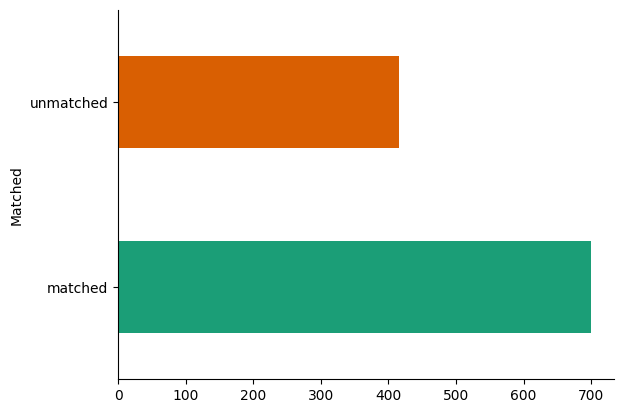

In [241]:
from matplotlib import pyplot as plt
import seaborn as sns
db_pomoci_flagged_new.groupby('Matched').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [191]:
db_pomoci_flagged_new[~db_pomoci_flagged_new["web"].isna()].shape

(190, 9)

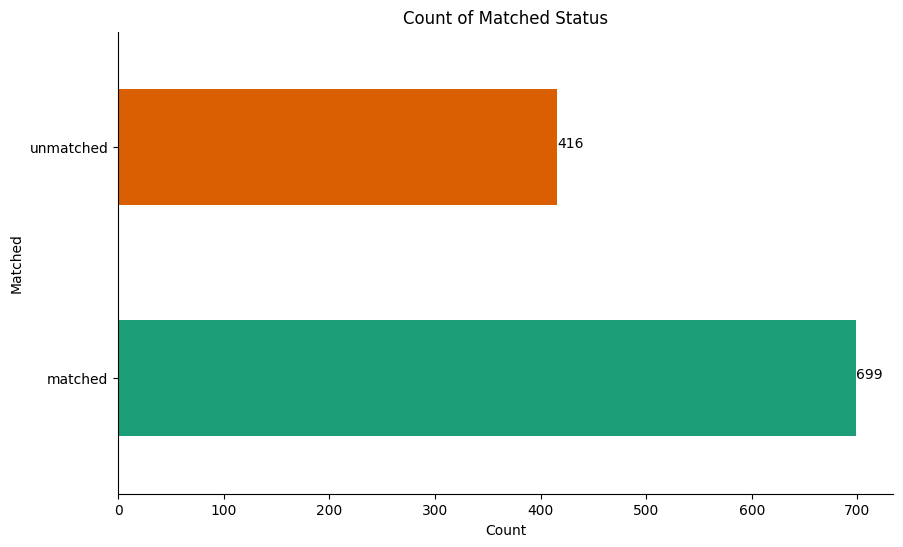

In [244]:
def plot_results(db_pomoci_flagged_new):
    db_pomoci_flagged_new = db_pomoci_flagged_new[~db_pomoci_flagged_new["Webová stránka"].isna()]
    grouped_data = db_pomoci_flagged_new.groupby('Matched').size()

    # Create a horizontal bar chart
    plt.figure(figsize=(10, 6))
    ax = grouped_data.plot(kind='barh', color=sns.color_palette('Dark2'))

    # Display the numbers on the chart
    for index, value in enumerate(grouped_data):
        plt.text(value, index, str(value))

    # Customize the plot
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xlabel('Count')
    plt.title('Count of Matched Status')
    plt.show()

plot_results(db_pomoci_flagged_new)

In [209]:
db_pomoci = pd.read_csv("../db_pomoci.csv")
def db_pomoci_transform(df:pd.DataFrame) -> pd.DataFrame:
    """
    This function prepare data initial data for validation
    """
    df['E-mail'] = df['E-mail'].apply(clean_email)
    ress_df = udf(df,"Telefon")
    df['Telefon'] = ress_df["formated_number"]
    df = df[~df["Webová stránka"].isna()]
    df.loc[df['Webová stránka'].str.startswith('www'), 'web'] = df['Webová stránka'].str.replace('^www', 'https://www', regex=True)
    return df
db_pomoci = db_pomoci_transform(db_pomoci)
print(db_pomoci[~db_pomoci["Webová stránka"].isna()].shape)
maps_results = pd.read_csv("../data/maps_results.csv", delimiter=";")
print(maps_results.shape)
maps_contacts = pd.concat([
    maps_results[['Email']].rename(columns={'Email': 'Contact'}),
    maps_results[['API Phone']].rename(columns={'API Phone': 'Contact'})
    ]).dropna().drop_duplicates()
print(maps_results.shape)
scraped_contacts = combined_df[['Contact']].dropna().drop_duplicates()
def check_contact(contact, contacts_df, source_name):
    """
    Check if a contact exists in the given contacts DataFrame.
    """
    if contact in contacts_df['Contact'].values:
        return source_name
    return None

def match_contact(row, maps_contacts, scraped_contacts):
    """
    Match contact details in the row with known contact sources.
    """
    sources = set()

    # Check against maps contacts
#         if check_contact(row['E-mail'], maps_contacts, 'maps_contacts'):
#             sources.add('maps_contacts_e_mail')
    if check_contact(row['Telefon'], maps_contacts, 'maps_contacts'):
        sources.add('maps_contacts_telefon')

    # Check against scraped contacts
    if check_contact(row['E-mail'], scraped_contacts, 'scraped_contacts'):
        sources.add('scraped_contacts_email')
    if check_contact(row['Telefon'], scraped_contacts, 'scraped_contacts'):
        sources.add('scraped_contacts_telefon')

    if sources:
        return 'matched', ', '.join(sources)
    return 'unmatched', None

db_pomoci[['Matched', 'Source']] = db_pomoci.apply(
lambda row: pd.Series(match_contact(row, maps_contacts, scraped_contacts)), axis=1)
print(db_pomoci.shape)
print(db_pomoci[~db_pomoci["Webová stránka"].isna()].shape)

/var/folders/rd/l77bltt96_97jdz4bbkmq5z40000gn/T/ipykernel_6207/1904062678.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['Webová stránka'].str.startswith('www'), 'web'] = df['Webová stránka'].str.replace('^www', 'https://www', regex=True)


(1117, 8)
(1456, 11)
(1456, 11)


(1117, 10)
(1117, 10)


In [207]:
import pandas as pd

# Load the initial contact database
db_pomoci = pd.read_csv("../db_pomoci.csv")

def clean_email(email):
    # Implement your email cleaning logic here
    return email

def udf(df, column):
    # Mock implementation of the udf function
    df['formated_number'] = df[column].astype(str).str.replace('.0', '')
    return df

def db_pomoci_transform(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function prepares initial data for validation.
    """
    df['E-mail'] = df['E-mail'].apply(clean_email)
    ress_df = udf(df, "Telefon")
    df['Telefon'] = ress_df["formated_number"]
    df = df[~df["Webová stránka"].isna()]
    
    # Ensure proper URL formatting
    df['web'] = df['Webová stránka']
    df.loc[df['web'].str.startswith('www'), 'web'] = df['web'].str.replace('^www', 'https://www', regex=True)
    
    return df

db_pomoci = db_pomoci_transform(db_pomoci)
print(db_pomoci[~db_pomoci["Webová stránka"].isna()].shape)

maps_results = pd.read_csv("../data/maps_results.csv", delimiter=";")
print(maps_results.shape)

maps_contacts = pd.concat([
    maps_results[['Email']].rename(columns={'Email': 'Contact'}),
    maps_results[['API Phone']].rename(columns={'API Phone': 'Contact'})
]).dropna().drop_duplicates()

print(maps_contacts.shape)

scraped_contacts = combined_df[['Contact']].dropna().drop_duplicates()

def check_contact(contact, contacts_df, source_name):
    """
    Check if a contact exists in the given contacts DataFrame.
    """
    if contact in contacts_df['Contact'].values:
        return source_name
    return None

def match_contact(row, maps_contacts, scraped_contacts):
    """
    Match contact details in the row with known contact sources.
    """
    sources = set()

    # Check against maps contacts
    if check_contact(row['Telefon'], maps_contacts, 'maps_contacts'):
        sources.add('maps_contacts_telefon')

    # Check against scraped contacts
    if check_contact(row['E-mail'], scraped_contacts, 'scraped_contacts'):
        sources.add('scraped_contacts_email')
    if check_contact(row['Telefon'], scraped_contacts, 'scraped_contacts'):
        sources.add('scraped_contacts_telefon')

    if sources:
        return 'matched', ', '.join(sources)
    return 'unmatched', None

db_pomoci[['Matched', 'Source']] = db_pomoci.apply(
    lambda row: pd.Series(match_contact(row, maps_contacts, scraped_contacts)), axis=1)

print(db_pomoci.shape)
print(db_pomoci[~db_pomoci["web"].isna()].shape)


/var/folders/rd/l77bltt96_97jdz4bbkmq5z40000gn/T/ipykernel_6207/1929717824.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['web'] = df['Webová stránka']


(1117, 8)
(1456, 11)
(1849, 1)
(1117, 10)
(1117, 10)


In [208]:
db_pomoci.head()

,Název,Kategorie,Adresa,E-mail,Telefon,Webová stránka,formated_number,web,Matched,Source
0,CDZ Hradec Králové (PDZ),CDZ - Centrum duševního zdraví,"Kavčí plácek 121/1, Hradec Králové (část) 500 ...",pdz-hk@pdz.cz,778 526 216,http://www.pdz.cz,778 526 216,http://www.pdz.cz,matched,"scraped_contacts_email, maps_contacts_telefon"
1,CDZ Opava (Fokus Opava),CDZ - Centrum duševního zdraví,"Ostrožná 27/244, Opava 746 01, Moravskoslezský...",fokusopava@seznam.cz,"553 652 433, 723 457 998",http://www.cdzopava.cz/,"553 652 433, 723 457 998",http://www.cdzopava.cz/,unmatched,None
2,CDZ Chrudim (PDZ),CDZ - Centrum duševního zdraví,"Městský park 828, Chrudim III (část) 537 01, P...",pdz-cr@pdz.cz,"469 626 383, 774 915 755",http://www.pdz.cz,"469 626 383, 774 915 755",http://www.pdz.cz,matched,scraped_contacts_email
3,CDZ Přerov (Duševní zdraví),CDZ - Centrum duševního zdraví,"Kosmákova 44, Přerov, Přerov I-Město 750 02, O...",tym@cdzprerov.cz,583 035 220,http://dusevnizdravi.com/centrum-dusevniho-zdr...,583 035 220,http://dusevnizdravi.com/centrum-dusevniho-zdr...,matched,maps_contacts_telefon
4,Psychiatrická ambulance Karlovy Vary,Psychiatrická ambulance,"Krymská 1799/25A, Karlovy Vary 360 01, Karlova...",vaclav.ferus@seznam.cz,353 230 878,https://mudr-vaclav-ferus.zdravotniregistr.cz/,353 230 878,https://mudr-vaclav-ferus.zdravotniregistr.cz/,matched,maps_contacts_telefon


In [245]:
df_scraped_1_06_full = pd.read_csv("../data/2_06/db_pomoci_flagged_new_V2.csv")


#"http://www.psychoterapeuti.cz/adresar-psychoterapeutu/item/67-sojka-vlastimil-phdr"

In [246]:
df_scraped_1_06_full.head()

,Název,Kategorie,Adresa,E-mail,Telefon,Webová stránka,web,Matched,Source
0,CDZ Hradec Králové (PDZ),CDZ - Centrum duševního zdraví,"Kavčí plácek 121/1, Hradec Králové (část) 500 ...",pdz-hk@pdz.cz,4.207785e+11,http://www.pdz.cz,NaN,matched,"scraped_contacts_telefon, scraped_contacts_email"
1,CDZ Opava (Fokus Opava),CDZ - Centrum duševního zdraví,"Ostrožná 27/244, Opava 746 01, Moravskoslezský...",fokusopava@seznam.cz,NaN,http://www.cdzopava.cz/,NaN,unmatched,NaN
2,CDZ Chrudim (PDZ),CDZ - Centrum duševního zdraví,"Městský park 828, Chrudim III (část) 537 01, P...",pdz-cr@pdz.cz,NaN,http://www.pdz.cz,NaN,matched,scraped_contacts_email
3,CDZ Přerov (Duševní zdraví),CDZ - Centrum duševního zdraví,"Kosmákova 44, Přerov, Přerov I-Město 750 02, O...",tym@cdzprerov.cz,4.205830e+11,http://dusevnizdravi.com/centrum-dusevniho-zdr...,NaN,matched,"scraped_contacts_telefon, scraped_contacts_email"
4,Psychiatrická ambulance Karlovy Vary,Psychiatrická ambulance,"Krymská 1799/25A, Karlovy Vary 360 01, Karlova...",vaclav.ferus@seznam.cz,4.203532e+11,https://mudr-vaclav-ferus.zdravotniregistr.cz/,NaN,unmatched,NaN


In [214]:
df_scraped_1_06_full[ (df_scraped_1_06_full['Base Website'].str.contains(r'\.sojka-vlastimil-phdr.+'))].sort_values(by="Base Website").tail(30)

,Unnamed: 0.1,Unnamed: 0,Base Website,Scraped Page,Page Type,Emails,Phone Numbers


In [238]:
def ensure_url_format(url):
    if not (url.startswith('www') or url.startswith('http') or url.startswith('https')):
        return 'www.' + url
    return url
def data_prep(subset: bool = False) -> pd.DataFrame:
    db_pomoci = pd.read_csv("../db_pomoci.csv")
    print("Original DataFrame shape:", len(set(db_pomoci["Webová stránka"])))
    db_pomoci = db_pomoci[["Webová stránka","E-mail","Telefon"]]
    # Rename columns for consistency
    df = db_pomoci.rename(columns={"Webová stránka": "web", "E-mail": "email"})
    print("After renaming columns",len(set(df["web"])))

    # Define the blacklist
    black_list = [
        'http://www.dc-brno.cz',
        'www.freeklub.cz',
        'http://www.cszs.cz/',
        'http://www.fokustabor.cz/centrum-dusevniho-zdravi-_-komunitni-tym-tabor'
    ]

    # Filter out rows with NaN in 'web' and those in the blacklist
    df = df[(~df["web"].isna()) & (~df['web'].isin(black_list))]
    print("After filtering NaNs and blacklist", len(set(df["web"])))

    # Remove whitespace from 'web'
    df['web'] = df['web'].str.replace(r'\s+', '', regex=True)
    print("After removing whitespace",len(set(df["web"])))

    # Replace '.cz/...' with '.cz'
    df_replace = df.copy()
    df_replace.loc[df_replace['web'].str.contains(r'\.cz/.+'), 'web'] = df_replace['web'].str.replace(r'\.cz/.+', '.cz', regex=True)
    print("After replacing '.cz/...'", len(set(df_replace["web"])))
    # df.loc[df['web'].str.contains(r'\.cz/.+'), 'web'] = df['web'].str.replace(r'\.cz/.+', '.cz', regex=True)
    # print("After replacing '.cz/...'", len(set(df["web"])))

    # Apply the function to the 'web' column
    df['web'] = df['web'].apply(ensure_url_format)
    print("After to the 'web' column",len(set(df["web"])))

    # Replace 'www' with 'https://www'
    df.loc[df['web'].str.startswith('www'), 'web'] = df['web'].str.replace('^www', 'https://www', regex=True)
    print("Final result", len(set(df["web"])))

    # # Aggregate phone numbers and emails by 'web'
    # df_agg_tel = df.groupby("web")["Telefon"].agg(list).reset_index()
    # df_agg_email = df.groupby("web")["email"].agg(list).reset_index()

    # # Merge the aggregated dataframes
    # df_agg = pd.merge(df_agg_tel, df_agg_email, on="web")

    # # Rename columns for clarity
    # df_agg = df_agg.rename(columns={'web': 'web', 'Telefon': 'Telefon'})

    # If subset is True, return the first 100 rows
    df = pd.concat([df, df_replace]).drop_duplicates().reset_index(drop=True)
    print("Final combined DataFrame result", len(set(df["web"])))
    if subset:
        df = df.head(100)

    return df

db_pomoci = pd.read_csv("../db_pomoci.csv")
black_list = ['http://www.dc-brno.cz','www.freeklub.cz', 'http://www.cszs.cz/','http://www.fokustabor.cz/centrum-dusevniho-zdravi-_-komunitni-tym-tabor']
df = db_pomoci[(~db_pomoci["Webová stránka"].isna()) & (~db_pomoci['Webová stránka'].isin(black_list))]
print(len(set(db_pomoci["Webová stránka"])))
print(len(set(df["Webová stránka"])))
data = data_prep()
print(len(set(data["web"])))
#data[data['web'].str.contains(r'\.sojka-vlastimil-phdr.+')].sort_values(by="web").tail(30)

873
868
Original DataFrame shape: 873
After renaming columns 873
After filtering NaNs and blacklist 868
After removing whitespace 867
After replacing '.cz/...' 711
After to the 'web' column 866
Final result 865
Final combined DataFrame result 1162
1162


In [225]:
import pandas as pd

# Define the URL formatting function
def ensure_url_format(url):
    if not (url.startswith('www') or url.startswith('http') or url.startswith('https')):
        return 'www.' + url
    return url

# Define the data preparation function
def data_prep(subset: bool = False) -> pd.DataFrame:
    db_pomoci = pd.read_csv("../db_pomoci.csv")

    # Rename columns for consistency
    df = db_pomoci.rename(columns={"Webová stránka": "web", "Název": "nazev", "E-mail": "email"})
    print("After renaming columns:", df.shape)

    # Define the blacklist
    black_list = [
        'http://www.dc-brno.cz',
        'www.freeklub.cz',
        'http://www.cszs.cz/',
        'http://www.fokustabor.cz/centrum-dusevniho-zdravi-_-komunitni-tym-tabor'
    ]

    # Filter out rows with NaN in 'web' and those in the blacklist
    df = df[(~df["web"].isna()) & (~df['web'].isin(black_list))]
    print("After filtering NaNs and blacklist:", df.shape)

    # Remove whitespace from 'web'
    df['web'] = df['web'].str.replace(r'\s+', '', regex=True)
    print("After removing whitespace:", df.shape)

    # Replace '.cz/...' with '.cz'
    df.loc[df['web'].str.contains(r'\.cz/.+'), 'web'] = df['web'].str.replace(r'\.cz/.+', '.cz', regex=True)
    print("After replacing '.cz/...':", df.shape)

    # Apply the function to the 'web' column
    df['web'] = df['web'].apply(ensure_url_format)
    print("After ensuring URL format:", df.shape)

    # Replace 'www' with 'https://www'
    df.loc[df['web'].str.startswith('www'), 'web'] = df['web'].str.replace('^www', 'https://www', regex=True)
    print("After replacing 'www' with 'https://www':", df.shape)

    # Aggregate phone numbers and emails by 'web' and 'nazev' to preserve unique entries
    df_agg_tel = df.groupby(["web", "nazev"])["Telefon"].agg(list).reset_index()
    df_agg_email = df.groupby(["web", "nazev"])["email"].agg(list).reset_index()
    print("After aggregation:", df_agg_tel.shape, df_agg_email.shape)

    # Merge the aggregated dataframes
    df_agg = pd.merge(df_agg_tel, df_agg_email, on=["web", "nazev"])
    print("After merging aggregated dataframes:", df_agg.shape)

    # Rename columns for clarity
    df_agg = df_agg.rename(columns={'web': 'web', 'Telefon': 'Telefon', 'nazev': 'nazev', 'email': 'email'})

    # If subset is True, return the first 100 rows
    if subset:
        df_agg = df_agg.head(100)

    return df_agg

# Load the initial contact database
db_pomoci = pd.read_csv("../db_pomoci.csv")
print("Original DataFrame shape:", db_pomoci.shape)

# Prepare the data
data = data_prep()
print("Processed DataFrame shape:", data.shape)


Original DataFrame shape: (1456, 6)
After renaming columns: (1456, 6)
After filtering NaNs and blacklist: (1113, 6)
After removing whitespace: (1113, 6)
After replacing '.cz/...': (1113, 6)
After ensuring URL format: (1113, 6)
After replacing 'www' with 'https://www': (1113, 6)
After aggregation: (1098, 3) (1098, 3)
After merging aggregated dataframes: (1098, 4)
Processed DataFrame shape: (1098, 4)


In [226]:
data.head()

,web,nazev,Telefon,email
0,http://apsycholog.cz/,Mgr. Michaela Šichová,[734 785 170],[nan]
1,http://apsycholog.cz/,Mgr. Michaela Šťovíčková,[774 680 991],[nan]
2,http://brejlova.cz/,PHDR. DAGMAR BREJLOVÁ,[607 575 073],[dagmar@brejlova.cz]
3,http://bulovka.cz,"PhDr. Martin Dlabal, Ph.D.",[266 083 271],[hospital@homolka.cz]
4,http://centrumarcha.cz,Centrum Archa,[775 677 887],[centrumarcha@centrumarcha.cz]


In [227]:
len(set(data["web"]))

703